# Product Recognition on Store Shelves

In [1]:
print(":|")

:|


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [15]:
def print_image_path(image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

def print_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

## STEP A - Multiple Product Detection

Develop an object detection system to identify single instance of products given: one reference image for each item and a scene image. The system should be able to correctly identify all the product in the shelves image.

* The images with the products that must be detected are: *models/{0,1,11,19,24,25,26}.jpg*
* The test images are: *scenes/e{1,2,3,4,5}.png*

Let's print two examples.

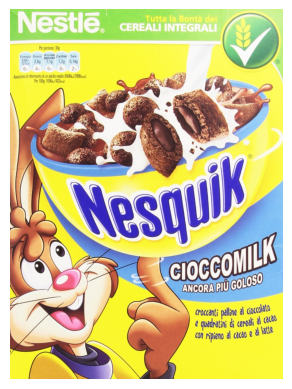

In [10]:
print_image('models/0.jpg')

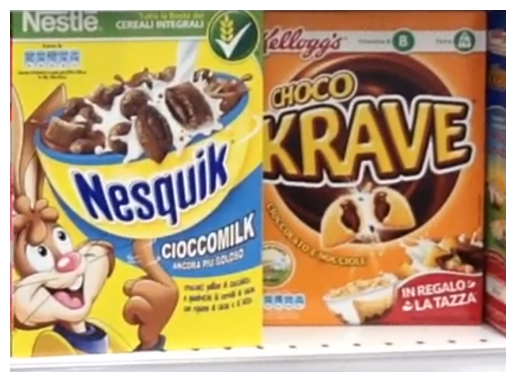

In [11]:
print_image('scenes/e1.png')

Let's detect keypoints in the model image.

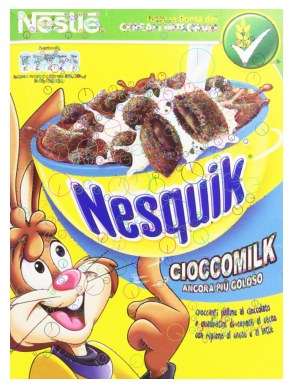

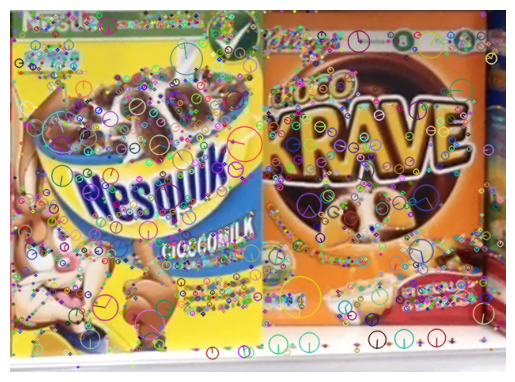

In [26]:
# Load the query and the train images
model_im = cv2.imread('models/0.jpg')
scene_im = cv2.imread('scenes/e1.png')

# Creating SIFT object
sift = cv2.SIFT_create()

# Detecting Keypoints in the
md_kp = sift.detect(model_im)
sc_kp = sift.detect(scene_im)

# Visualizing the found Keypoints
md_with_kp = cv2.drawKeypoints(model_im,md_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(md_with_kp)

sc_with_kp = cv2.drawKeypoints(scene_im,sc_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(sc_with_kp)

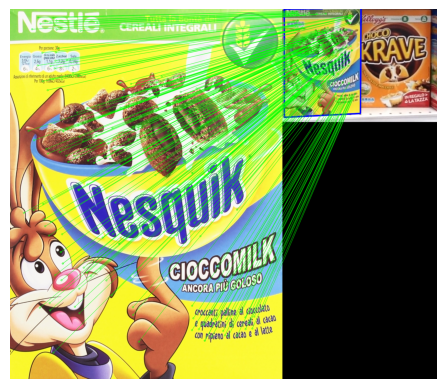

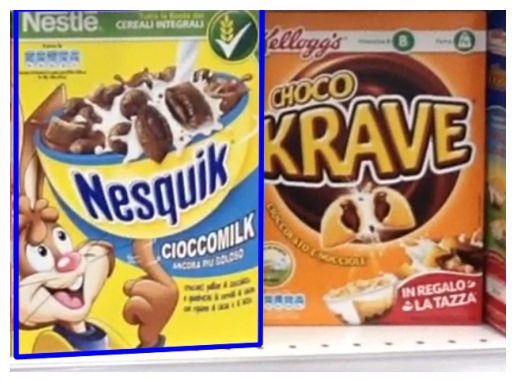

In [48]:
# Computing the descriptors for each keypoint
kp_model, des_model = sift.compute(model_im, md_kp)
kp_scene, des_scene = sift.compute(scene_im, sc_kp)

# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_model,des_scene,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)



# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = model_im.shape[0:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Drawing bounding box
    scene_im = cv2.polylines(scene_im,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(model_im,md_kp,scene_im,sc_kp,good,None,**draw_params)
print_image(img3)
print_image(scene_im)